In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
%matplotlib inline
import cv2
import torchvision
import torch
from PIL import Image,ImageFile
from os.path import isfile, join, abspath, exists, isdir, expanduser
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset,DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['pretrained-pytorch-models', 'aptos2019-blindness-detection']


In [5]:
#Import the labels,
train_labels=pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
test=pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
sample=pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")

In [6]:
train_labels.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [7]:
len(train_labels['id_code'])

3662

In [8]:
train_labels['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

The number of images with No DR is 1805 followed by Moderate DR and Mild DR.

In [9]:
test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [10]:
len(test['id_code'])

1928

In [11]:
sample.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [14]:
NUM_CLASS=5
BATCH_SIZE=64
IMAGE_SIZE=227
data_dir="../input/aptos2019-blindness-detection/"


In [15]:
train_x,valid_x,train_y,valid_y=train_test_split(train_labels,train_labels['diagnosis'],test_size=0.2,shuffle=train_labels['diagnosis'])

In [16]:
train_x.shape,train_y.shape,valid_x.shape,valid_y.shape

((2929, 2), (2929,), (733, 2), (733,))

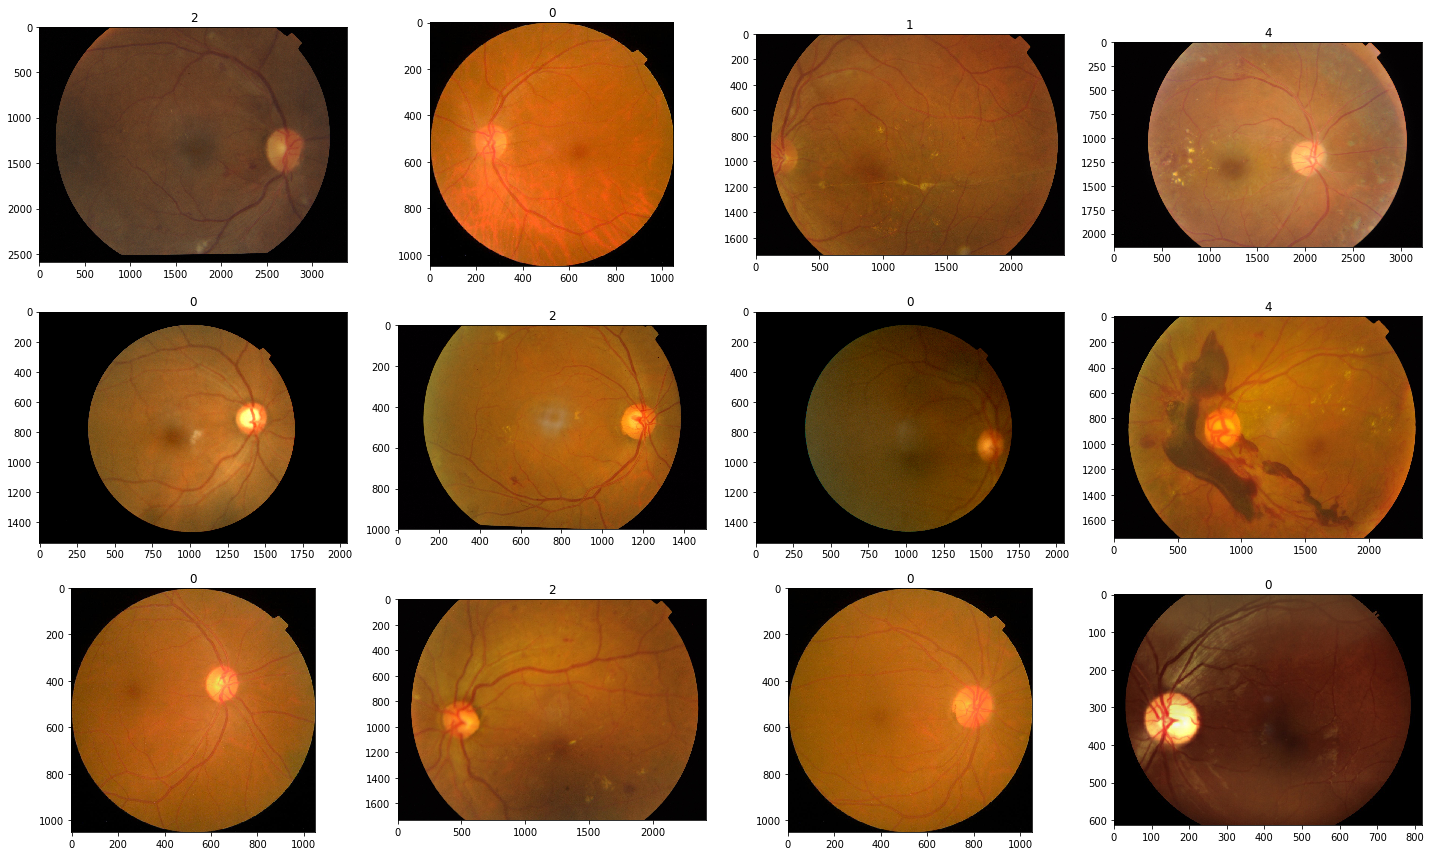

In [26]:
#Inspired from - https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_name = '{}.png'.format(df.iloc[i,0])  
        image_id = df.iloc[i,1]
        img_path=data_dir+'/train_images/'
        img_path=join(img_path,image_name)
        
        img = Image.open(img_path)
        
        
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_x)

In [44]:
## Import the data:
class eye(Dataset):
    def __init__(self,labels,directory,subset=False,transform=None):
        self.labels=labels
        self.directory=directory
        self.transform=transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        img_name='{}.png'.format(self.labels.iloc[idx,0])  
        full_image_path=join(self.directory,img_name)
        image=Image.open(full_image_path)
        image = image.resize((299, 299), resample=Image.BILINEAR)
        image_label=self.labels.iloc[idx,1:].as_matrix().astype('float')
        image_label=np.argmax(image_label)
        
        image=self.transform(image)
            
        return [image,image_label]
    

In [45]:
train_trans=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485,0.485,0.485],std=[0.485,0.485,0.485])])
test_trans=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485,0.485,0.485],std=[0.485,0.485,0.485])])
train_ds=eye(train_x,data_dir+'/train_images/',transform=train_trans)
valid_ds=eye(valid_x,data_dir+'/train_images/',transform=train_trans)

train_dl=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
valid_dl=DataLoader(valid_ds,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)


# Model Building

In [46]:
from torchvision import models

In [47]:
model=models.inception_v3(pretrained=False)
model.load_state_dict(torch.load("../input/pretrained-pytorch-models/inception_v3_google-1a9a5a14.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [48]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

The final linear layer in inception_v3 has 1000 out features.In our case,the total number of output classes is 5 .Therefore we need to modify the final layer.

In [49]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [50]:
final_in_features=model.fc.in_features
model.fc=nn.Linear(final_in_features,10,bias=True)
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [51]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [52]:
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=3e-04)


In [53]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
## work in progress..

In [54]:
# %%time
# loss_arr = []
# loss_epoch_arr = []
# max_epochs = 10

# for epoch in range(max_epochs):
#     model.train()
#     for i, (inputs,labels) in enumerate(train_dl,0):
        
#         #inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         with torch.set_grad_enabled(True):
        
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
            
#             loss.backward()
#             optimizer.step()
        
#         loss_arr.append(loss.item())
        
# loss_epoch_arr.append(loss.item())
        
# print('Epoch: %d/%d, Train acc: %0.2f, Valid acc: %0.2f' % (epoch, max_epochs, evaluation(train_dl), evaluation(valid_dl)))
    
    
# plt.plot(loss_epoch_arr)
# plt.show()

AttributeError: 'InceptionOuputs' object has no attribute 'log_softmax'

In [ ]:
# def prediction(data_loader):
#     model.eval()
#     test_pred = torch.LongTensor()
    
#     for i, data in enumerate(data_loader):
#         data = Variable(data, volatile=True)
#         if torch.cuda.is_available():
#             data = data.cuda()
            
#         output = model(data)
        
#         pred = output.cpu().data.max(1, keepdim=True)[1]
#         test_pred = torch.cat((test_pred, pred), dim=0)
        
#     return test_pred

In [ ]:
# test_pred=prediction(test_dl)

In [ ]:
# sample = pd.DataFrame(np.c_[np.arange(1, len(test_dl)+1)[:,None], test_pred.numpy()], 
#                       columns=['ImageId', 'Label'],index=None)

In [ ]:
# sample.to_csv("first_submission.csv",index=False)